In [1]:
import re
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.manifold import TSNE
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.layers import Dropout, Dense, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

df = pd.read_csv("./output/spam_encoded.csv")
df.head()

Using TensorFlow backend.


,spam,original_message,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,0,"Go until jurong point, crazy.. Available only ...",-0.142966,-0.225385,0.268059,0.065721,-0.100783,-0.198441,0.390656,0.337182,...,0.069544,-0.396520,0.011688,-0.208539,0.012130,-0.056947,-0.025428,-0.057884,0.165974,0.302198
1,0,Ok lar... Joking wif u oni...,-0.244984,-0.052506,0.137510,-0.623836,-0.311277,0.074931,0.652979,0.200019,...,0.070855,-0.541656,-0.040561,0.047741,-0.063776,-0.138928,0.041252,-0.045966,0.087562,0.546937
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,-0.389005,-0.030240,0.203487,-0.166000,0.020918,-0.139901,0.331638,0.095457,...,0.381351,-0.158719,-0.000505,-0.167245,0.169160,-0.084802,-0.366647,-0.106075,0.096242,0.567941
3,0,U dun say so early hor... U c already then say...,-0.090251,0.151952,0.069052,-0.610341,-0.220990,0.013123,0.301812,0.334780,...,0.196930,-0.408126,0.062470,0.140425,0.175495,-0.085699,-0.226141,-0.002507,0.255287,0.496604
4,0,"Nah I don't think he goes to usf, he lives aro...",0.056018,0.251125,-0.092620,-0.307521,-0.365732,-0.075228,0.414467,0.388034,...,-0.168950,-0.419398,-0.070503,-0.010642,0.323683,0.016842,-0.103515,-0.076240,0.479977,0.274191


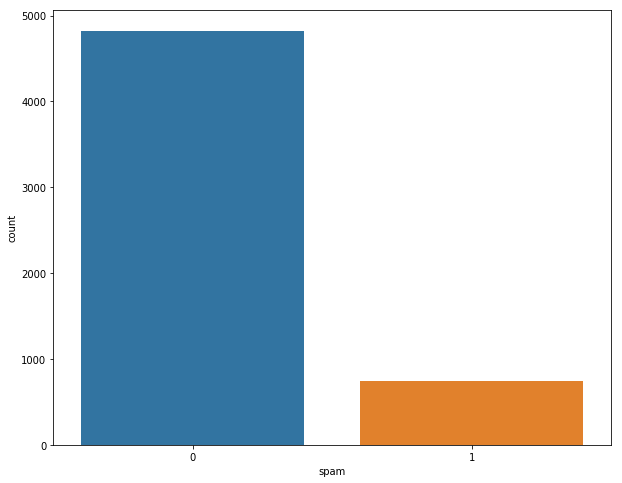

In [2]:
plt.subplots(figsize=(10,8))
ax = sns.countplot(x="spam", data=df)

In [3]:
df["spam"].value_counts()

0    4825
1     747
Name: spam, dtype: int64

We can see that there is the same amout of class imbalance as in the original dataset: **13.41%** of messages are spam

# Basic feature engineering

Adding just some counts based on the original messages (number of words, number of characters, etc.)

In [4]:
# Count the number of words in the message
df["num_words"] = df["original_message"].apply(lambda s: len(re.findall(r'\w+', s)))

# Get the length of the text message
df["message_len"] = df["original_message"].apply(len)

# Count the number of uppercased characters
df["num_uppercase_chars"] = df["original_message"].apply(lambda s: sum(1 for c in s if c.isupper())) 

# Count the numbe rof uppercased words
df["num_uppercase_words"] = df["original_message"].apply(lambda s: len(re.findall(r"\b[A-Z][A-Z]+\b", s)))

# Check if the message contains the word "free" or "win"
df["contains_free_or_win"] = df["original_message"].apply(lambda s: int("free" in s.lower() or "win" in s.lower()))

# Standardizing features

For better performance in algorithms that optimize a loss-function it is best if every feature is in the same scale. To this end lets standardize all features except the binary features and the original text column

In [5]:
# Initialize StandardScaler
scaler = preprocessing.StandardScaler()

# Dont standerdize binary columns and the text column
feats_to_scale = df.drop(["spam", "original_message", "contains_free_or_win"], axis=1)

# Create a new dataframe with the standardized features
scaled_features = pd.DataFrame(scaler.fit_transform(feats_to_scale))
scaled_features.rename(
    {768: "num_words", 769:"message_len", 770: "num_uppercase_chars", 771: "num_uppercase_words"},
    axis=1,
    inplace=True
)

# Update the dataset with the new standerdized features
scaled_df = df.copy()
scaled_df.update(scaled_features)

C:\Users\lsfischer\AppData\Local\Continuum2\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\lsfischer\AppData\Local\Continuum2\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


# Train-Test split

We'll leave a held out test set and perform our analysis on the training set

In [6]:
X = scaled_df.drop(["spam", "original_message"], axis=1)
y = scaled_df["spam"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Exploratory data analysis

Here the idea is to get a sense of the data.

First we can see the manifold distribution of the data using T-SNE, where we can see how the embeddings encode the messages

In [7]:
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_train)

Creating additional dataframes for plotting

In [8]:
# creating the dataframe for plotting
def creat_plotting_data(data, labels=y_train, rename=False):
    """Creates a dataframe from the given data, used for plotting"""
    
    df = pd.DataFrame(data)
    df["spam"] = labels.to_numpy()
    
    if rename:
        df.rename({0:"v1", 1:"v2"}, axis=1, inplace=True)
        
    return df

# creating the dataframes for plotting
plotting_data_embedded = creat_plotting_data(X_embedded, rename=True)

# T-SNE visualization of SMS messages

We can see how the messages are distributed in manifold space. Since we have the BERT embedings for every message it should produce interesting results

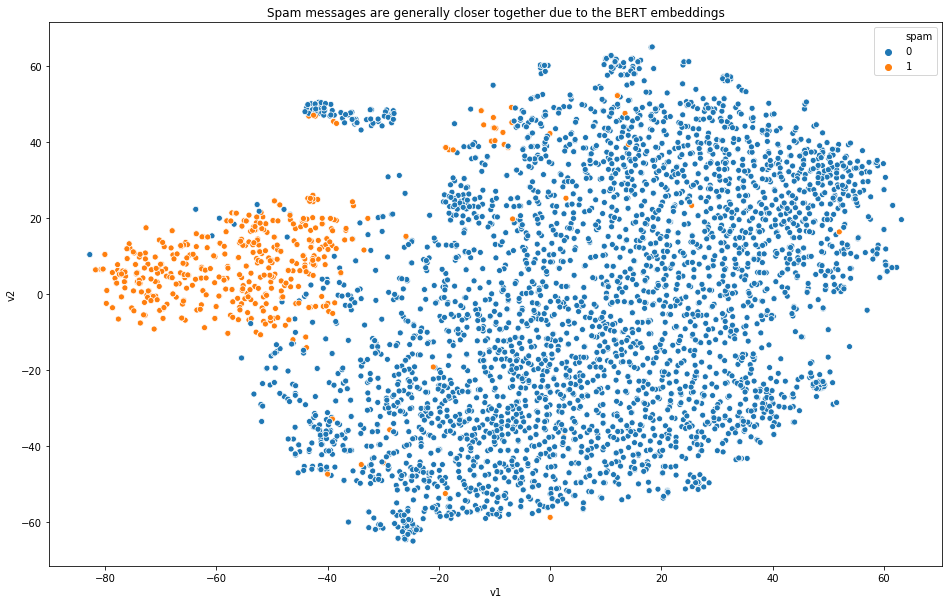

In [9]:
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="v1", y="v2", hue="spam", data=plotting_data_embedded)
ax.set(title = "Spam messages are generally closer together due to the BERT embeddings")
plt.show()

We clearly see that the BERT embeddings together with the additional engineered features we get a training set where spam messages are quite close together with some outliers amongst ham messages.

# Do spam messages have more words than ham messages?

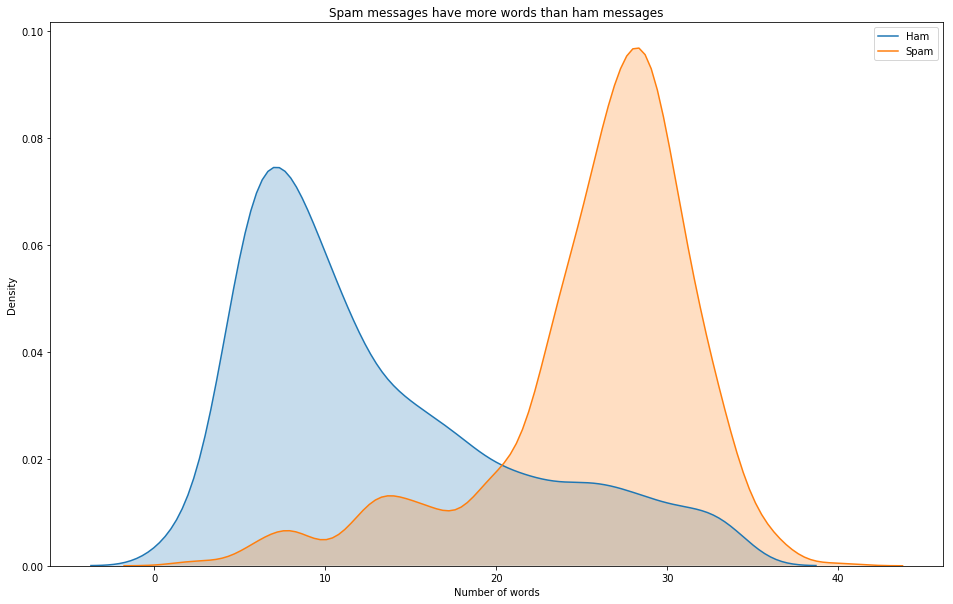

In [10]:
_,ax = plt.subplots(figsize=(16,10))
sns.kdeplot(df.loc[df.spam == 0, "num_words"], shade=True, label="Ham", clip=(0, 35)) # removing observations with message length above 35 because there is an outlier
sns.kdeplot(df.loc[df.spam == 1, "num_words"], shade=True, label="Spam")
ax.set(xlabel = "Number of words", ylabel = "Density",title = "Spam messages have more words than ham messages")
plt.show()

This plot shows us that yes **spam** messages, generally, have **more words** than ham messages. 

**Spam** messages seem to be concentrated around 30 words while **ham** messages are concentrated around 10 words

# Is there any pattern in the length of the messages?

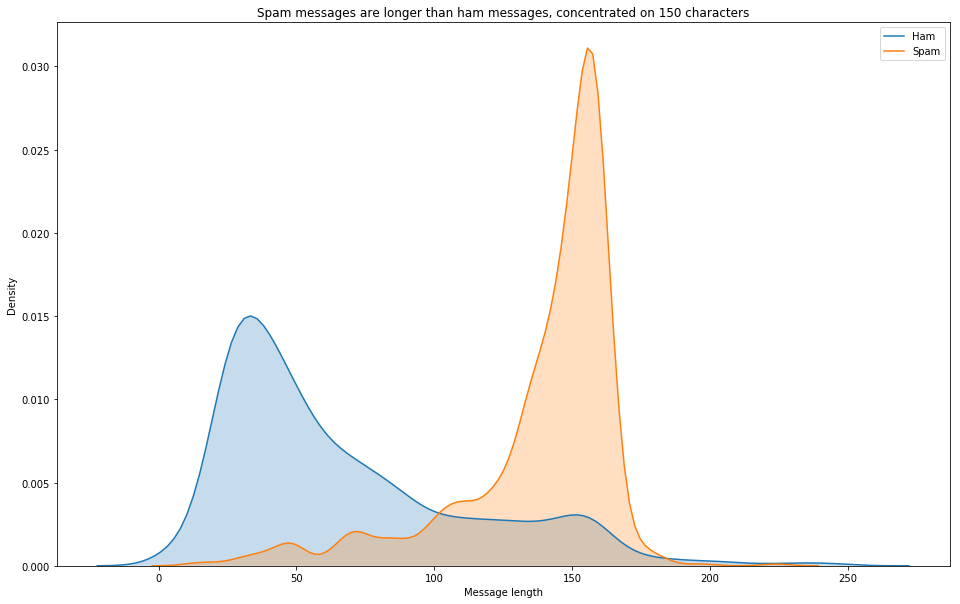

In [11]:
_,ax = plt.subplots(figsize=(16,10))
sns.kdeplot(df.loc[df.spam == 0, "message_len"], shade=True, label="Ham", clip=(0, 250)) # removing observations with message length above 250 because there is an outlier
sns.kdeplot(df.loc[df.spam == 1, "message_len"], shade=True, label="Spam")
ax.set(xlabel = "Message length", ylabel = "Density",title = "Spam messages are longer than ham messages, concentrated on 150 characters")
plt.show()

This plots shows two things:

- Spam messages are, generally, longer than ham messages (which is to be expected since they have more words)
- There seems to be a common value of around 150 characters for spam messages

# Do spam messages have more uppercased words?

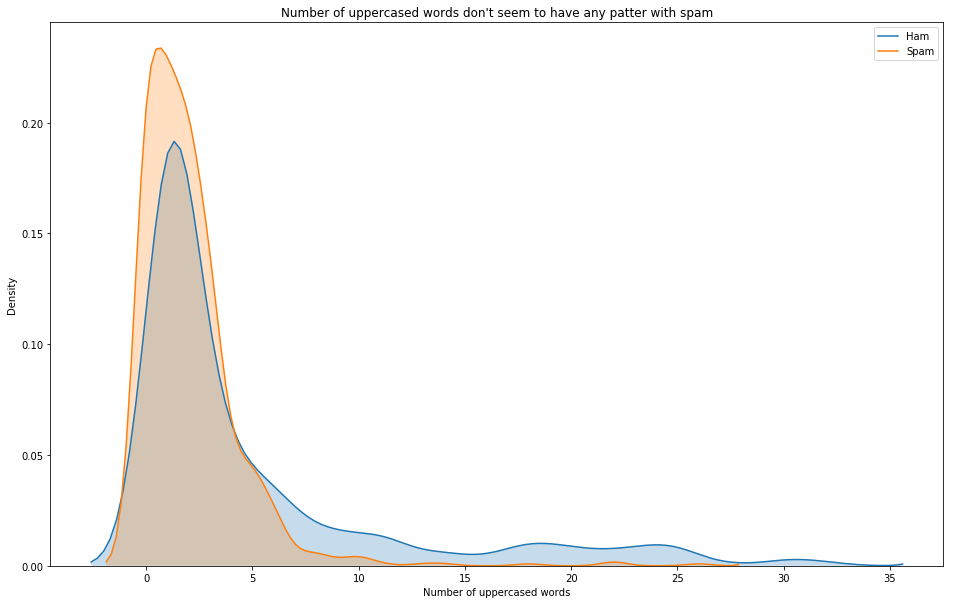

In [12]:
_,ax = plt.subplots(figsize=(16,10))
sns.kdeplot(df.loc[df.spam == 0, "num_uppercase_words"], shade=True, label="Ham", clip=(0, 250)) # removing observations with message length above 250 because there is an outlier
sns.kdeplot(df.loc[df.spam == 1, "num_uppercase_words"], shade=True, label="Spam")
ax.set(xlabel = "Number of uppercased words", ylabel = "Density",title = "Number of uppercased words don't seem to have any patter with spam")
plt.show()

So the number of uppercased words does not seem to have any particular pattern with Spam

## Is having the word "free" or "win"  more associated with spam messages?

   spam  contains_free_or_win  Percentage of group
0     0                     0             0.973057
1     0                     1             0.026943
2     1                     0             0.630522
3     1                     1             0.369478


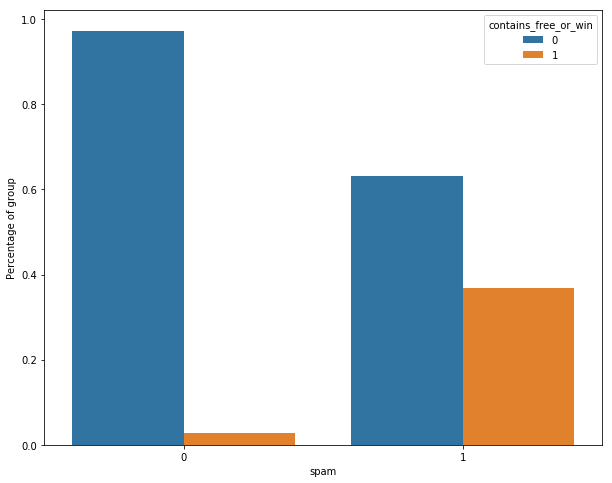

In [13]:
plt.subplots(figsize=(10,8))

# Get the proportion of the genders grouped by the attrition status
grouped_data = df.groupby("spam")["contains_free_or_win"].value_counts(normalize = True).rename("Percentage of group").reset_index()
print(grouped_data)

# Plot the result
ax = sns.barplot(x="spam", y="Percentage of group", hue="contains_free_or_win", data=grouped_data)

- **36.95% of spam** messages contain the word "free" or "win"
- Only **2.69% of ham** messages contain the word "free" or "win"

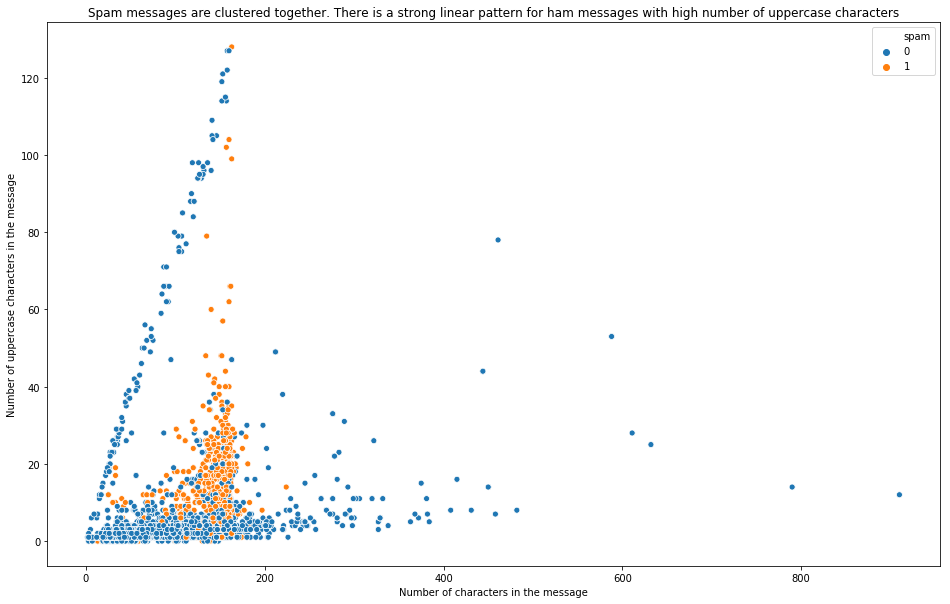

In [14]:
plt.subplots(figsize=(16,10))
ax = sns.scatterplot(x="message_len", y="num_uppercase_chars", hue="spam", data=df)
ax.set(
    xlabel="Number of characters in the message",
    ylabel="Number of uppercase characters in the message",
    title="Spam messages are clustered together. There is a strong linear pattern for ham messages with high number of uppercase characters")
plt.show()

- **Spam** messages are really clustered together in terms of message length with some spam messages having more uppercase characters than others

- There is a strong linear pattern for **ham** messages with higher number of uppercased characters

# Simple neural net

To demonstrate the efficiency of the embeddings we'll create a simple neural network

## Defining the architecture of the network

Lets go for a 1000-256-256-128-10-1 layered network, not particular reason for it.

We'll add dropout to help prevent overfitting and batchnorm for better convergence

In [15]:
model = Sequential()

model.add(Dense(1000, input_shape=(773,), activation="relu"))
model.add(BatchNormalization(axis=-1))

model.add(Dense(256, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

model.add(Dense(256, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))

model.add(Dense(128, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

model.add(Dense(10, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

model.add(Dense(1, activation="sigmoid"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Compiling the network

We'll use a RMSProp optimizer with 0.001 learning rate but we'll reduce this learning rate by half if the validation accuracy has not increased in the last 3 epochs (we should not be using accuracy since its a skewed dataset but it will do for now)

In [16]:
# defining the learning rate, the number of epochs and the batch size
INIT_LR = 0.001
NUM_EPOCHS = 30
BS = 64
opt = RMSprop(lr = INIT_LR)

# This is just a necessary step to compile the model, we don't actually need it because we're not using the old model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

# Reduce the learning rate by half if validation accuracy has not increased in the last 3 epochs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

fitted_network = model.fit(X_train, y_train, validation_split=0.2, batch_size=BS, epochs=NUM_EPOCHS, callbacks=[learning_rate_reduction])

Instructions for updating:
Use tf.cast instead.
Train on 3343 samples, validate on 836 samples
Epoch 1/30
3343/3343 [==============================] - 4s 1ms/step - loss: 0.4760 - acc: 0.7786 - val_loss: 0.3113 - val_acc: 0.9366
Epoch 2/30
3343/3343 [==============================] - 2s 569us/step - loss: 0.3335 - acc: 0.9103 - val_loss: 0.1931 - val_acc: 0.9821
Epoch 3/30
3343/3343 [==============================] - 2s 547us/step - loss: 0.2451 - acc: 0.9608 - val_loss: 0.1097 - val_acc: 0.9916
Epoch 4/30
3343/3343 [==============================] - 2s 544us/step - loss: 0.1813 - acc: 0.9740 - val_loss: 0.1867 - val_acc: 0.9545
Epoch 5/30
3343/3343 [==============================] - 2s 551us/step - loss: 0.1510 - acc: 0.9773 - val_loss: 0.1075 - val_acc: 0.9785
Epoch 6/30
3343/3343 [==============================] - 2s 544us/step - loss: 0.1033 - acc: 0.9832 - val_loss: 0.0584 - val_acc: 0.9904

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/30

# Run predictions on the test set

Our network achieved pretty good results in the training and validation data, let's see if that is the case for the test set as well

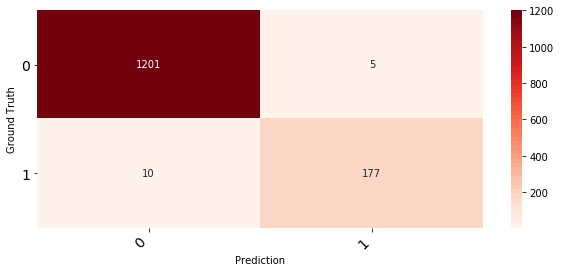

Accuray: 98.923%
ROC-AUC: 0.97119
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1206
           1       0.97      0.95      0.96       187

   micro avg       0.99      0.99      0.99      1393
   macro avg       0.98      0.97      0.98      1393
weighted avg       0.99      0.99      0.99      1393



In [35]:
# predict results
preds = np.round(model.predict(X_test)).flatten()

# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(y_test, preds)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(y_test, preds), 5) * 100}%
ROC-AUC: {round(roc_auc_score(y_test, preds), 5)}""")
print(classification_report(y_test, preds))

# Results

It is clear that our network with the BERT embeddings and the engineered features achieved great results

- Retrieved 95% of all spam messages
- Of all those messages the network said were spam, it was right 97% of the times
- Only 5 ham messages were missclassified

For comparison in my [first analysis](https://www.kaggle.com/mrlucasfischer/bert-the-spam-detector-that-uses-just-10-words) I created a baseline random forest (with no hyperparameter tunning) that achieved 0.8806 ROC-AUC

Hope this helps get started using this dataset, and I hope this motivates with the usefulness of the BERT embeddings

Cheers! :)